# Demonstrative Examples

In [1]:
import numpy as np
import pandas as pd

## 1. Load sample dataset

In [2]:
# alarm data
alarms = pd.read_csv(r'./sample/alarm.csv')
# causal_prior
causal_prior= np.load(r'./sample/causal_prior.npy')
# ground_truths, this file will not be provided in the submission stage
true_graph = np.load(r'./sample/true_graph.npy')

print(f"shape of alarm data: {alarms.shape}")
print(f"shape of true graph: {true_graph.shape}")
print(f"shape of causal prior matrix: {causal_prior.shape}")

# Notes: topology.npy and rca_prior.csv are not used in this demo code.

shape of alarm data: (30691, 4)
shape of true graph: (59, 59)
shape of causal prior matrix: (59, 59)


## 2.  Select the gCastle as the base algorithm library

In [4]:
from castle.algorithms import Notears,PC
from castle.common.plot_dag import GraphDAG
from castle.metrics import MetricsDAG
from castle.common.priori_knowledge import PrioriKnowledge

## 3. Case Studies

### 3.1 Setting 1:

  1. Data files: "alarm.csv".
  2. Use a time sliding window to generate IID samples.

In [5]:
TIME_WIN_SIZE  = 300

In [6]:
alarms = alarms.sort_values(by='start_timestamp')
alarms['win_id'] = alarms['start_timestamp'].map(lambda elem:int(elem/TIME_WIN_SIZE))

samples=alarms.groupby(['alarm_id','win_id'])['start_timestamp'].count().unstack('alarm_id')
samples = samples.dropna(how='all').fillna(0)
samples = samples.sort_index(axis=1)

In [7]:
samples.head(3)

alarm_id,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
win_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,3.0,0.0,3.0,1.0,0.0


In [8]:
samples.shape

(1981, 59)

####  Exemplified by the NOTEARS

In [9]:
nt = Notears()
nt.learn(samples)

2023-08-08 20:26:27,975 - /home/zhangkeli/anaconda3/lib/python3.9/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=1981, d=59, iter_=100, h_=1e-08, rho_=1e+16
2023-08-08 20:26:28,224 - /home/zhangkeli/anaconda3/lib/python3.9/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=1.433e-01, loss=15.762, rho=1.0e+00
2023-08-08 20:26:28,327 - /home/zhangkeli/anaconda3/lib/python3.9/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=1.295e-01, loss=11.476, rho=1.0e+00
2023-08-08 20:26:28,460 - /home/zhangkeli/anaconda3/lib/python3.9/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=8.740e-02, loss=11.568, rho=1.0e+01
2023-08-08 20:26:28,625 - /home/zhangkeli/anaconda3/lib/python3.9/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=4.041e-02, loss=12.493, rho=1.0e+02
2023-08-08 20:26:28,880 - /home/zhangkeli/

In [10]:
nt_estimated_graph = nt.causal_matrix

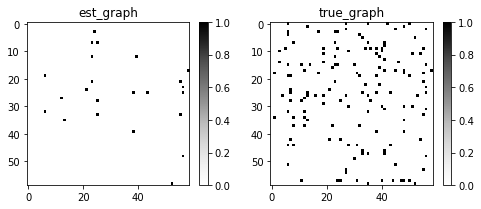

In [11]:
# Plot estimated graph and true graph
GraphDAG(nt_estimated_graph, true_graph)

In [12]:
# Evaluation 
nt_metrics = MetricsDAG(nt_estimated_graph, true_graph)
print(f"The performance for notears: \n{nt_metrics.metrics}")

The performance for notears: 
{'fdr': 0.087, 'tpr': 0.1429, 'fpr': 0.0013, 'shd': 126, 'nnz': 23, 'precision': 0.913, 'recall': 0.1429, 'F1': 0.2471, 'gscore': 0.1293}


### 3.2 Setting 2:

  1. Data files: "alarm.csv" and 'causal_prior.csv'.
  2. Use a time sliding window to generate IID samples.

In [13]:
# create the prior knowledge object for the PC algorithm 
prior_knowledge = PrioriKnowledge(causal_prior.shape[0])
for i, j in zip(*np.where(causal_prior == 1)):
    prior_knowledge.add_required_edge(i, j)

for i, j in zip(*np.where(causal_prior == 0)):
    prior_knowledge.add_forbidden_edge(i, j)

#### Exemplified by the PC supporting prior knowledge injection

In [14]:
pc = PC(priori_knowledge=prior_knowledge)
pc.learn(samples)

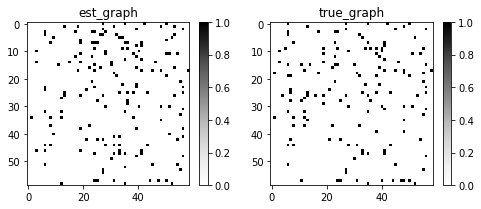

In [15]:
pc_estimated_graph = pc.causal_matrix
# Plot estimated graph and true graph
GraphDAG(pc_estimated_graph, true_graph)

In [16]:
# Evaluation 
pc_metrics = MetricsDAG(pc_estimated_graph, true_graph)
print(f"The performance for PC with Prior Knowledge: \n{pc_metrics.metrics}")

The performance for PC with Prior Knowledge: 
{'fdr': 0.3252, 'tpr': 0.7483, 'fpr': 0.0339, 'shd': 72, 'nnz': 163, 'precision': 0.6748, 'recall': 0.7483, 'F1': 0.7097, 'gscore': 0.3878}
